In [1]:
import sys
sys.path.append('..')

from ib_insync import *
from BacktestApp import BacktestApp

ba = BacktestApp(config_file="../config_backtest.yml", clientId=18, debug=True)

成功连接到IBKR（18）


In [ ]:
from StructureReserve import StructureReserve
for contract, today, minutes in ba.daily_unorder_iterator("20250214", "200 D"):
    data_process = StructureReserve()
    for bars in ba.custom_iterator_minute_data(minutes, data_process.prepare_data): # 预先调用这个函数，避免重复计算的时间开支
        bars = bars.copy() # 避免SettingWithCopyWarning报错
        
        structure = StructureReserve()
        structure.data = bars
        structure.has_prepare_data = True
        
        structure.update(contract, bars, ba.pm)

【2024-09-23 10:37:00-04:00】【Structure】开仓: TSLA, 价格: 248.03, 数量：410, 浮动盈亏：None
【2024-09-23 10:43:00-04:00】【Structure】平仓: TSLA, 价格: 248.18, 数量：-410, 浮动盈亏：61.50000000000233
【2024-09-24 13:37:00-04:00】【Structure】开仓: TSLA, 价格: 252.62, 数量：400, 浮动盈亏：None
【2024-09-24 13:51:00-04:00】【Structure】平仓: TSLA, 价格: 252.25, 数量：-400, 浮动盈亏：-148.00000000000182
【2024-09-25 11:07:00-04:00】【Structure】开仓: TSLA, 价格: 254.86, 数量：-400, 浮动盈亏：None
【2024-09-25 11:15:00-04:00】【Structure】平仓: TSLA, 价格: 254.87, 数量：400, 浮动盈亏：-3.999999999996362
【2024-09-26 10:08:00-04:00】【Structure】开仓: TSLA, 价格: 259.49, 数量：-390, 浮动盈亏：None
【2024-09-26 10:13:00-04:00】【Structure】平仓: TSLA, 价格: 258.91, 数量：390, 浮动盈亏：226.1999999999938
【2024-09-27 15:18:00-04:00】【Structure】开仓: TSLA, 价格: 259.98, 数量：390, 浮动盈亏：None
【2024-09-27 15:20:00-04:00】【Structure】平仓: TSLA, 价格: 260.04, 数量：-390, 浮动盈亏：23.400000000000887
【2024-09-27 15:22:00-04:00】【Structure】开仓: TSLA, 价格: 260.05, 数量：390, 浮动盈亏：None
【2024-09-27 15:25:00-04:00】【Structure】平仓: TSLA, 价格: 260.15, 数量：-390,

KeyboardInterrupt: 

In [6]:
import pandas as pd
trade_log = ba.pm.trade_log
df = pd.DataFrame(trade_log)
df

,date,symbol,strategy,open_or_close,direction,price,amount,commission,pnl
0,2024-09-23 10:37:00-04:00,TSLA,Structure,开仓,BUY,248.03,410,8.135384,NaN
1,2024-09-26 10:08:00-04:00,TSLA,Structure,开仓,SELL,259.49,-390,8.096088,NaN
2,2024-09-23 10:43:00-04:00,TSLA,Structure,平仓,SELL,248.18,-410,8.140304,61.5
3,2024-09-26 10:13:00-04:00,TSLA,Structure,平仓,BUY,258.91,390,8.077992,226.2
4,2024-09-25 11:07:00-04:00,TSLA,Structure,开仓,SELL,254.86,-400,8.155520,NaN
...,...,...,...,...,...,...,...,...,...
2693,2025-02-13 15:03:00-05:00,SOXL,Structure,平仓,SELL,28.36,-3550,8.054240,-177.5
2694,2025-02-13 15:16:00-05:00,SOXL,Structure,开仓,BUY,28.41,3550,8.068440,NaN
2695,2025-02-13 15:19:00-05:00,SOXL,Structure,平仓,SELL,28.42,-3550,8.071280,35.5
2696,2025-02-13 15:21:00-05:00,SOXL,Structure,开仓,BUY,28.41,3550,8.068440,NaN


In [7]:
ba.statistic()

{'cumulative_pnl': np.float64(42359.60000000012),
 'max_drawdown': np.float64(0.0)}

In [9]:
df["commission"].sum()

np.float64(21760.865744000002)

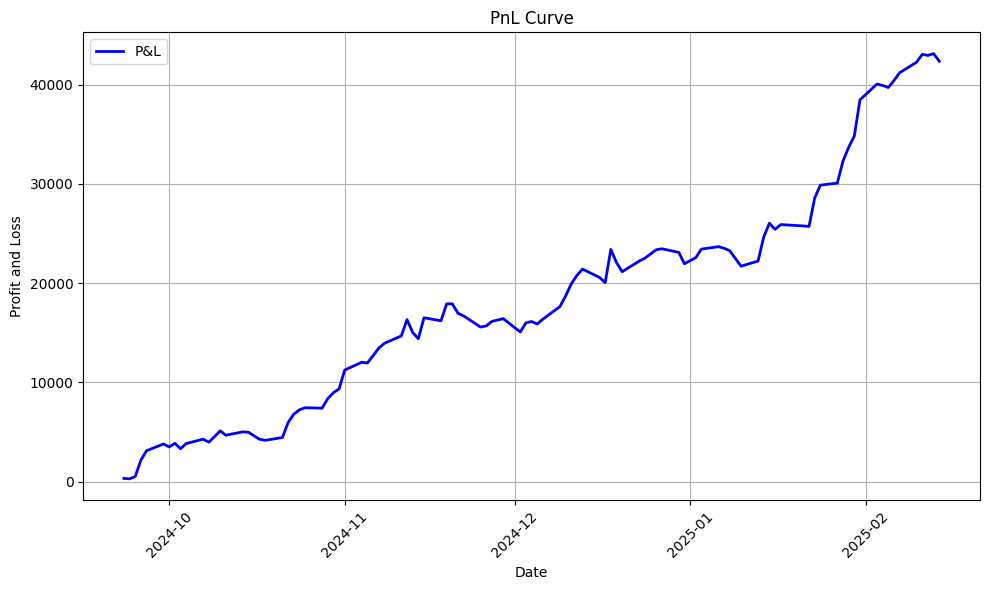

In [8]:
ba.plot_pnl()

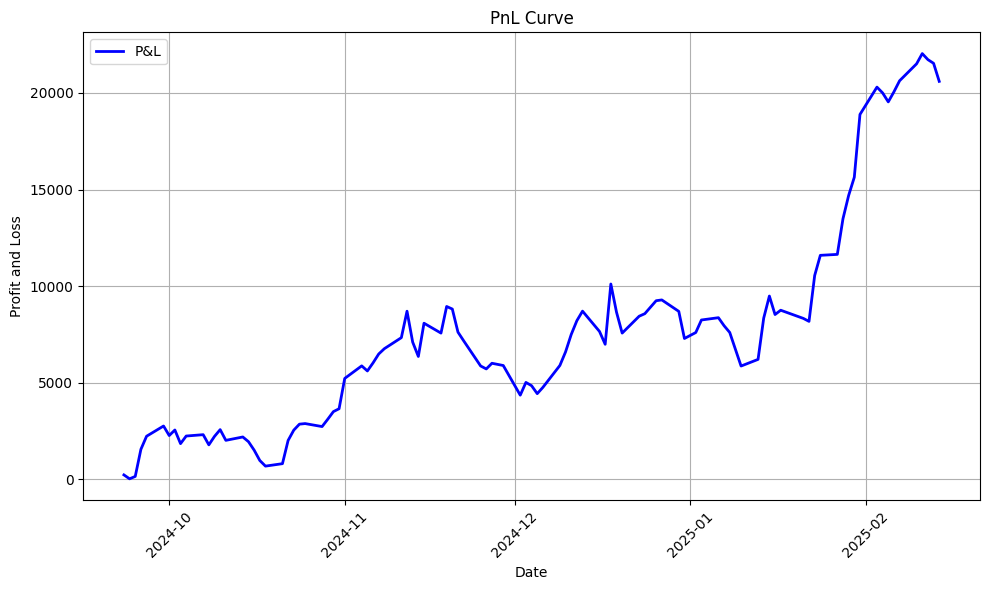

In [10]:
import matplotlib.pyplot as plt
df = pd.DataFrame(ba.pm.trade_log)

if df.empty or "pnl" not in df.columns or "commission" not in df.columns:
    print("交易日志为空，或缺少 pnl/commission 列，无法绘制盈亏曲线。")
else:
    # 确保 date 是 datetime 类型，并去掉时间部分（按天计算）
    df["date"] = pd.to_datetime(df["date"]).dt.date

    # 填充 NaN pnl 为 0（开仓时没有 pnl）
    df["pnl"] = df["pnl"].fillna(0)
    df["commission"] = df["commission"].fillna(0)

    # 扣减佣金后的盈亏
    df["net_pnl"] = df["pnl"] - df["commission"]

    # 按日期求和，计算每日净收益
    daily_pnl = df.groupby("date")["net_pnl"].sum().reset_index()

    # 计算累计收益
    daily_pnl["cumulative_pnl"] = daily_pnl["net_pnl"].cumsum()

    # 绘制盈亏曲线
    plt.figure(figsize=(10, 6))
    plt.plot(daily_pnl["date"], daily_pnl["cumulative_pnl"], label="P&L", color='b', linewidth=2)
    plt.xlabel("Date")
    plt.ylabel("Profit and Loss")
    plt.title("PnL Curve")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [16]:
def max_concurrent_positions(ba):
    """
    计算最多同时持有的股票种类数。
    """
    # 初始化 DataFrame
    df = pd.DataFrame(ba.pm.trade_log)

    if df.empty or "direction" not in df.columns or "symbol" not in df.columns:
        print("交易日志为空，或缺少 side/symbol 列，无法计算最大持仓种类数。")
        return 0

    # 按交易时间排序，确保顺序是正确的
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date")

    # 初始化持仓股票集合
    positions = set()
    max_positions = 0

    # 遍历每一笔交易
    for _, row in df.iterrows():
        symbol = row["symbol"]
        if row["direction"] == "BUY":  # 买入操作，加入持仓股票集合
            positions.add(symbol)
        elif row["direction"] == "SELL":  # 卖出操作，移除持仓股票集合
            if symbol in positions:
                positions.remove(symbol)

        # 更新最大同时持有股票种类数
        max_positions = max(max_positions, len(positions))

    return max_positions

max_concurrent_positions(ba)

12